In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [242]:
pd.set_option('display.max_columns', None)

In [243]:
games_details = pd.read_csv('./data/games_details.csv')
games = pd.read_csv('./data/games.csv')
players = pd.read_csv('./data/players.csv')
ranking = pd.read_csv('./data/ranking.csv')
teams = pd.read_csv('./data/teams.csv')

/tmp/ipykernel_18194/3421045274.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  games_details = pd.read_csv('./data/games_details.csv')


We want to add game dates/season to the data so that we can group performance by time and track stationarity.

In [244]:
game_dates = games[['GAME_DATE_EST', 'SEASON', 'GAME_ID']]
game_dates.loc[:, 'GAME_DATE_EST'] = pd.to_datetime(game_dates['GAME_DATE_EST'])

In [245]:
games_details = game_dates.merge(games_details, on='GAME_ID', how='inner')

Here we checked/cleaned for dupes/NA

In [248]:
games_details.groupby(by=['GAME_ID', 'PLAYER_ID'])['TEAM_ID'].count()[games_details.groupby(by=['GAME_ID', 'PLAYER_ID'])['TEAM_ID'].count() > 1]

Series([], Name: TEAM_ID, dtype: int64)

In the below we will assume the fixed relationships:
* 2*FGM + FG3M + FTM = PTS
* xM / xA = x_PCT  for x $\in$ [FG, FG3, FT]
* OREB + DREB = REB

So we won't explore these colinearities.</br>
Although, we can use them to check for errors in the data.

In [247]:
cols = [
    'GAME_DATE_EST',
    'SEASON',
    'GAME_ID',
    'PLAYER_ID',
    'START_POSITION',
    'MIN',
    'FGM',
    'FGA',
    'FG_PCT',
    'FG3M',
    'FG3A',
    'FG3_PCT',
    'FTM',
    'FTA',
    'FT_PCT',
    'OREB',
    'DREB',
    'REB',
    'AST',
    'STL',
    'BLK',
    'TO',
    'PF',
    'PTS'
]
games_details.dropna(subset=['MIN', 'PTS'], how='all', inplace=True)  # completely empty
games_details.drop_duplicates(subset=['GAME_ID', 'PLAYER_ID'], inplace=True)  # there exact are duplicates

In [370]:
print((np.abs(2*games_details['FGM'] + games_details['FG3M'] + games_details['FTM'] - games_details['PTS']) > 0.001).sum())
print((np.abs(games_details['FGM']/games_details['FGA'] - games_details['FG_PCT']) > 0.001).sum())
print((np.abs(games_details['FG3M']/games_details['FG3A'] - games_details['FG3_PCT']) > 0.001).sum())
print((np.abs(games_details['FTM']/games_details['FTA'] - games_details['FT_PCT']) > 0.001).sum())
print((np.abs(games_details['OREB'] + games_details['DREB'] - games_details['REB']) > 0.001).sum())

0
0
0
0
0


We see that the errors are likely in Points, in particular since the relationships between Made/Attempted = Percent are correct.</br>
So let's simply correct it.

In [367]:
games_details[(np.abs(2*games_details['FGM'] + games_details['FG3M'] + games_details['FTM'] - games_details['PTS']) > 0.001)]

,GAME_DATE_EST,SEASON,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,MIN_LEN,MIN_NUM
413698,2005-10-11 00:00:00,2005,10500006,1610612747,LAL,Los Angeles,2567,Brian Cook,NaN,NA,NaN,23,3.0,8.0,0.375,0.0,1.0,0.0,1.0,4.0,0.250,0.0,5.0,5.0,2.0,1.0,0.0,0.0,3.0,10.0,NaN,2,23.0
445495,2004-10-27 00:00:00,2004,10400102,1610612750,MIN,Minnesota,1519,John Thomas,NaN,NA,NaN,5,1.0,3.0,0.333,1.0,1.0,1.0,1.0,2.0,0.500,1.0,5.0,6.0,1.0,2.0,0.0,4.0,2.0,1.0,NaN,1,5.0
445587,2004-10-27 00:00:00,2004,10400100,1610612753,ORL,Orlando,2730,Dwight Howard,NaN,NA,NaN,5,5.0,7.0,0.714,1.0,1.0,1.0,4.0,7.0,0.571,3.0,10.0,13.0,1.0,0.0,0.0,3.0,1.0,14.0,NaN,1,5.0
445756,2004-10-26 00:00:00,2004,10400092,1610612755,PHI,Philadelphia,243,Aaron McKie,NaN,NA,NaN,5,1.0,3.0,0.333,1.0,1.0,1.0,1.0,2.0,0.500,0.0,1.0,1.0,3.0,1.0,0.0,1.0,3.0,1.0,NaN,1,5.0
446208,2004-10-22 00:00:00,2004,10400069,1610612747,LAL,Los Angeles,1885,Lamar Odom,NaN,NA,NaN,5,3.0,11.0,0.273,1.0,1.0,1.0,7.0,8.0,0.875,2.0,7.0,9.0,3.0,0.0,0.0,3.0,3.0,13.0,NaN,1,5.0


In [369]:
games_details['PTS'] = (2*games_details['FGM'] + games_details['FG3M'] + games_details['FTM'])

Here we clean up the MIN column. We see 3 variants that we treat with the function 'str2min'

In [249]:
games_details['MIN_LEN'] = games_details['MIN'].apply(lambda x: len(x))
games_details[['MIN_LEN'] + cols].groupby(by='MIN_LEN').sample()

,MIN_LEN,GAME_DATE_EST,SEASON,GAME_ID,PLAYER_ID,START_POSITION,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
445820,1,2004-10-25 00:00:00,2004,10400087,905,NaN,5,1.0,2.0,0.500,0.0,0.0,0.000,1.0,2.0,0.5,2.0,7.0,9.0,1.0,1.0,2.0,0.0,3.0,3.0
179365,2,2012-10-15 00:00:00,2012,11200046,2545,NaN,16,3.0,5.0,0.600,0.0,0.0,0.000,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,1.0,3.0,1.0,6.0
471786,4,2003-11-26 00:00:00,2003,20300205,788,NaN,2:56,1.0,1.0,1.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
282583,5,2009-03-28 00:00:00,2008,20801088,101235,F,35:49,8.0,17.0,0.471,3.0,7.0,0.429,2.0,2.0,1.0,3.0,6.0,9.0,3.0,1.0,0.0,4.0,2.0,21.0
5776,11,2022-11-21 00:00:00,2022,22200255,1631323,NaN,6.000000:53,1.0,4.0,0.250,0.0,3.0,0.000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0
16677,12,2022-04-19 00:00:00,2021,42100152,1627736,NaN,22.000000:06,3.0,6.0,0.500,1.0,2.0,0.500,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,2.0,2.0,7.0


In [250]:
def str2min(min_str):
    if len(min_str) <= 2:
        return float(min_str) # likely to be minutes and not seconds
    if len(min_str) <= 5:
        return int(min_str[:2].strip(':')) + int(min_str[-2])/60
    else:
        return int(min_str[:2].strip('.')) + int(min_str[-2])/60

games_details['MIN_NUM'] = games_details['MIN'].apply(str2min)

# replace MIN by MIN_NUM
cols.pop(5)
cols.insert(5, 'MIN_NUM')
cols

['GAME_DATE_EST',
 'SEASON',
 'GAME_ID',
 'PLAYER_ID',
 'START_POSITION',
 'MIN_NUM',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TO',
 'PF',
 'PTS']

Most of the data is missing the start position. We may explore this later. Perhaps we can infer the start position from other stats.

In [251]:
games_details.loc[games_details['START_POSITION'].isna(), 'START_POSITION'] = 'NA'

In [252]:
games_details[['START_POSITION', 'PLAYER_ID']].groupby(by='START_POSITION').count()

,PLAYER_ID
START_POSITION,
C,51128
F,102259
G,102257
NA,303026


In [253]:
games_details[cols].groupby(by='START_POSITION').sample()

,GAME_DATE_EST,SEASON,GAME_ID,PLAYER_ID,START_POSITION,MIN_NUM,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
462521,2004-01-21 00:00:00,2003,20300598,2048,C,32.066667,5.0,8.0,0.625,0.0,0.0,0.0,7.0,9.0,0.778,1.0,6.0,7.0,3.0,0.0,1.0,2.0,5.0,17.0
81329,2021-01-09 00:00:00,2020,22000139,203516,F,20.050000,2.0,5.0,0.400,0.0,2.0,0.0,0.0,0.0,0.000,0.0,2.0,2.0,1.0,3.0,0.0,1.0,0.0,4.0
544523,2017-12-16 00:00:00,2017,21700429,202689,G,37.066667,7.0,26.0,0.269,0.0,9.0,0.0,0.0,0.0,0.000,1.0,5.0,6.0,6.0,1.0,0.0,2.0,2.0,14.0
435662,2004-12-27 00:00:00,2004,20400392,2553,NA,25.000000,3.0,9.0,0.333,0.0,1.0,0.0,6.0,6.0,1.000,2.0,4.0,6.0,1.0,3.0,0.0,1.0,2.0,12.0


Here we look at a single player's performance stats as a time series. We see that there could be some underlying 'shape' (correlations)

/home/zenome/.pyenv/versions/3.12.2/envs/huggingface/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


<Axes: xlabel='GAME_DATE_EST'>

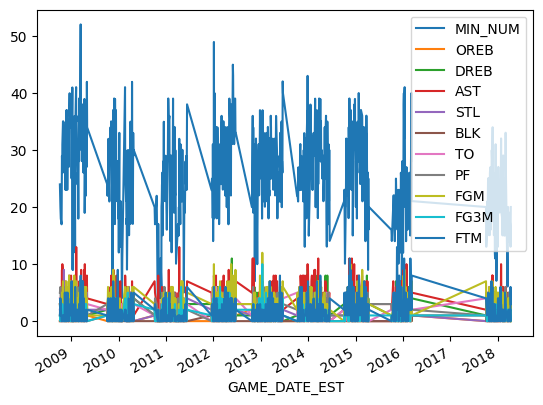

In [254]:
allPerfCols = ['MIN_NUM', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']
# perfCols = ['MIN_NUM', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']
perfCols = ['MIN_NUM', 'OREB', 'DREB' , 'AST', 'STL', 'BLK', 'TO', 'PF', 'FGM', 'FG3M', 'FTM']
games_details[games_details['PLAYER_ID'] == 201596][['GAME_DATE_EST'] + perfCols].sort_values('GAME_DATE_EST').plot(x='GAME_DATE_EST', y=perfCols)

Below we see our first interesting latent correlations that track well from season to season:
* The more game time for this player (Feature 0) translate to higher additive stats in particular stats
* Stats are: 'DREB' , 'AST', 'STL', 'TO', 'PF', 'FGM'
* Aditionally, we see that in later seasons, 'FTM' becomes sensitive, but this is not a good stationary choice

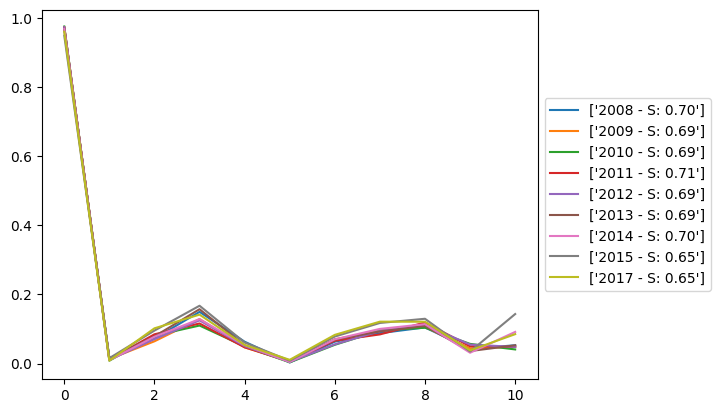

In [275]:
dim = 0
for season, stats in games_details[games_details['PLAYER_ID'] == 201596][['SEASON'] + perfCols].groupby(by='SEASON')[perfCols]:
    U, S, V = np.linalg.svd(stats)
    sgn = np.sign(V[dim][np.argmax(np.abs(V[dim]))])  # flip reversed dim
    plt.plot(V[dim]*sgn, label=[f'{season} - S: {S[dim]/S.sum():0.2f}'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

It's a bit tough to understand this concept, but let's take a look at an example:
* Suppose we use seasons 2008-2010 to build our 'model' (using this word loosely)
* Then we want to test the above relationship, and what it tells us is that the difference between a game's result and this latent dim is up to scale:
$$ G_i = L * s_i $$
* where $ G_i $ are the features ['MIN_NUM', 'DREB' , 'AST', 'STL', 'TO', 'PF', 'FGM'] for game $ i $
* $ L $ is the stationary latent vector above
* $ s_i $ is the scaling factor for game $ i $

A good way to test this theory is to solve for $ s_i $ of each game:
$$ s_i = \sum_{features}{G_i} / \sum_{features}{L} $$

Then to check our hypothesis, let's plot the error terms by feature:
$$ \epsilon =  G_i - L * s_i $$



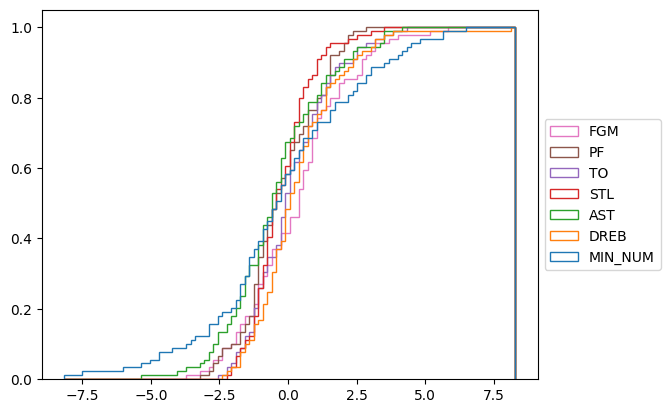

In [309]:
dim = 0
L = np.zeros([11])
for season, stats in games_details[(games_details['PLAYER_ID'] == 201596) & (games_details['SEASON'] <= 2010)][['SEASON'] + perfCols].groupby(by='SEASON')[perfCols]:
    U, S, V = np.linalg.svd(stats)
    sgn = np.sign(V[dim][np.argmax(np.abs(V[dim]))])  # flip reversed dim
    L += V[dim]*sgn
L /= 3
L = L[[0, 2, 3, 4, 6, 7, 8]]
ssn11 = games_details[(games_details['PLAYER_ID'] == 201596) & (games_details['SEASON'] == 2011)][['MIN_NUM', 'DREB' , 'AST', 'STL', 'TO', 'PF', 'FGM']].values
scale = ssn11.sum(1) / L.sum()
histogram = plt.hist((ssn11 - L*scale[..., np.newaxis]), bins=100, density=True, histtype='step', cumulative=True, label=['MIN_NUM', 'DREB' , 'AST', 'STL', 'TO', 'PF', 'FGM'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We see that these errors are incredibly normally distributed. This is not by mistake, but by design of PCA.</br>
Furthermore, if we additively combine these features, then it will work to reduce the overall errors.

I am not very familiar with the types of bets in the sports world, but let's price some kind of bet that exploits this finding.</br>
As long as someone will take the opposite bet, I guess it is a good product :-)

In [322]:
np.round(L[0]/L[1:]/6)  # Find some point system for each Feature - divided by total features

array([2., 1., 3., 3., 2., 2.])

Based on these numbers, let's declare that each type of action/feature is worth some points:
'DREB' : 2, 'AST': 1, 'STL': 3, 'TO': 3, 'PF': 2, 'FGM': 2

For example, if the player gets a Defensive Rebound, then he gets 2 points.</br>
Then our bet is that the player will accumulate as many or more points as minutes that he played.

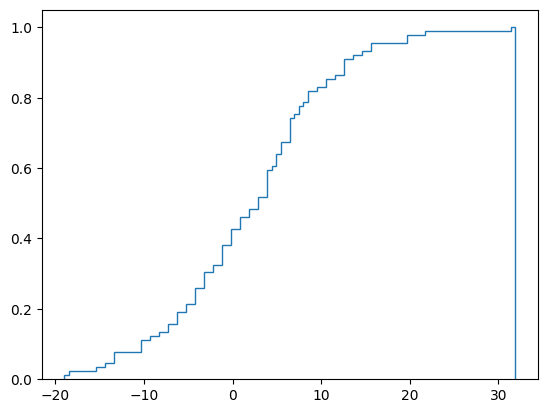

In [323]:
points = np.round(L[0]/L[1:]/6)
minPlayed, pointsAccumulated = ssn11[:, 0] , ssn11[:, 1:] @ np.array(points)
histogram = plt.hist(pointsAccumulated - minPlayed, bins=100, density=True, histtype='step', cumulative=True)

We can also focus on a subset of features, but it will increase our variability. Let's try it, by focusing on DREB, AST, FGM.
But now the points are 4, 3, 3

[4. 3. 3.]


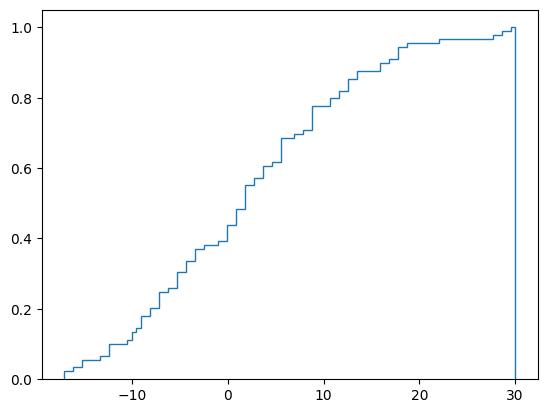

In [337]:
points = np.round(L[0]/L[[1, 2, 6]]/3)
print(points)
minPlayed, pointsAccumulated = ssn11[:, 0] , ssn11[:, [1, 2, 6]] @ np.array(points)
histogram = plt.hist(pointsAccumulated - minPlayed, bins=100, density=True, histtype='step', cumulative=True)

Enough of that.

The next latent set of features are not stationary, so as far as using more of the same strategy, we cannot.

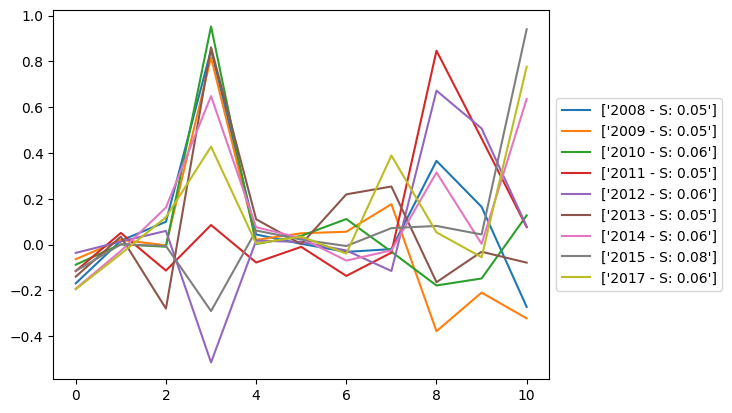

In [274]:
dim = 1
for season, stats in games_details[games_details['PLAYER_ID'] == 201596][['SEASON'] + perfCols].groupby(by='SEASON')[perfCols]:
    U, S, V = np.linalg.svd(stats)
    sgn = np.sign(V[dim][np.argmax(np.abs(V[dim]))])  # flip reversed dim
    plt.plot(V[dim]*sgn, label=[f'{season} - S: {S[dim]/S.sum():0.2f}'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

What about other players?

In [353]:
players[players['PLAYER_ID'] == 202711]

,PLAYER_NAME,TEAM_ID,PLAYER_ID,SEASON
1,Bojan Bogdanovic,1610612762,202711,2019
829,Bojan Bogdanovic,1610612754,202711,2018
1480,Bojan Bogdanovic,1610612754,202711,2017
2156,Bojan Bogdanovic,1610612764,202711,2016
2589,Bojan Bogdanovic,1610612751,202711,2016
3152,Bojan Bogdanovic,1610612751,202711,2015
3568,Bojan Bogdanovic,1610612751,202711,2014


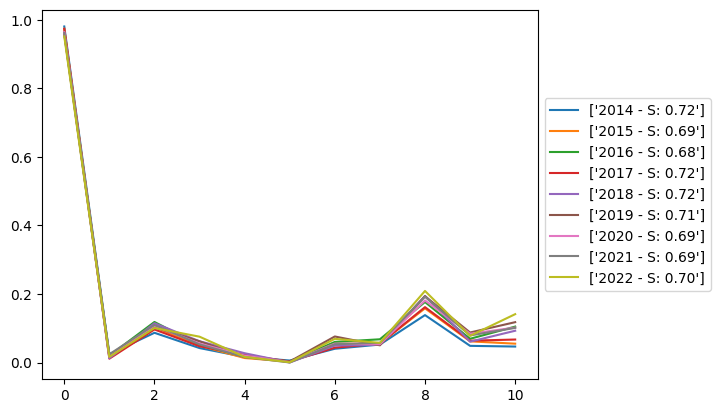

In [354]:
dim = 0
for season, stats in games_details[games_details['PLAYER_ID'] == 202711][['SEASON'] + perfCols].groupby(by='SEASON')[perfCols]:
    U, S, V = np.linalg.svd(stats)
    sgn = np.sign(V[dim][np.argmax(np.abs(V[dim]))])  # flip reversed dim
    plt.plot(V[dim]*sgn, label=[f'{season} - S: {S[dim]/S.sum():0.2f}'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

A very stationary behaviour across seasons - but with a slightly different distribution. Again, FTM is somewhat less stationary.

The same betting template could work here, as well.

In [375]:
import xgboost as xgb

Let's switch gears, but remaining in the same spirit of trying to measure a player's performance, season-by-season.</br>
We can use XGBoost to also find these correlations quite fast.</br>
As an example, let's check if we can predict Points from the other columns (of course we can b/c of the fixed relationship).

In [505]:
checkIdx = 18

allPerfIdx = np.arange(len(allPerfCols))
xIdx = allPerfIdx[allPerfIdx != checkIdx]
yIdx = allPerfIdx[allPerfIdx == checkIdx]

trainData = games_details[(games_details['PLAYER_ID'] == 201596) & (games_details['SEASON'] <= 2010)][allPerfCols].values
trainX, trainY = trainData[:,xIdx], trainData[:,yIdx]
testData = games_details[(games_details['PLAYER_ID'] == 201596) & (games_details['SEASON'] == 2011)][allPerfCols].values
testX, testY = testData[:,xIdx], testData[:,yIdx]

In [465]:
XY = xgb.DMatrix(trainX, trainY)
testXY = xgb.DMatrix(testX, testY)

In [511]:
evals_result = dict()

bstr = xgb.train({
    'objective': 'reg:squarederror',
    # 'tree_method': 'hist',
    'booster': 'gblinear',
    # 'base_score': 3,
    # 'learning_rate': 0.1,
    # 'max_depth': 3,
    'alpha': 0.01,
    'lambda': 0.01,
}, XY, num_boost_round=1000, early_stopping_rounds=5, evals=[(XY, 'Train'), (testXY, 'Test')], evals_result=evals_result)

[0]	Train-rmse:4.30492	Test-rmse:4.46856
[1]	Train-rmse:3.62019	Test-rmse:3.87320


[2]	Train-rmse:3.15985	Test-rmse:3.25688
[3]	Train-rmse:2.81001	Test-rmse:2.79037
[4]	Train-rmse:2.55065	Test-rmse:2.49209
[5]	Train-rmse:2.33508	Test-rmse:2.14408
[6]	Train-rmse:2.14756	Test-rmse:2.01977
[7]	Train-rmse:2.03710	Test-rmse:1.89661
[8]	Train-rmse:1.88301	Test-rmse:1.75810
[9]	Train-rmse:1.78660	Test-rmse:1.69521
[10]	Train-rmse:1.73170	Test-rmse:1.63718
[11]	Train-rmse:1.66484	Test-rmse:1.58371
[12]	Train-rmse:1.53741	Test-rmse:1.49184
[13]	Train-rmse:1.51811	Test-rmse:1.44711
[14]	Train-rmse:1.45820	Test-rmse:1.35104
[15]	Train-rmse:1.33408	Test-rmse:1.32330
[16]	Train-rmse:1.30682	Test-rmse:1.27379
[17]	Train-rmse:1.24311	Test-rmse:1.21597
[18]	Train-rmse:1.19599	Test-rmse:1.14497
[19]	Train-rmse:1.09776	Test-rmse:1.06297
[20]	Train-rmse:1.04934	Test-rmse:1.00101
[21]	Train-rmse:0.98554	Test-rmse:0.92284
[22]	Train-rmse:0.90614	Test-rmse:0.87969
[23]	Train-rmse:0.86821	Test-rmse:0.84627
[24]	Train-rmse:0.82497	Test-rmse:0.81363
[25]	Train-rmse:0.79134	Test-rmse:0.78371


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

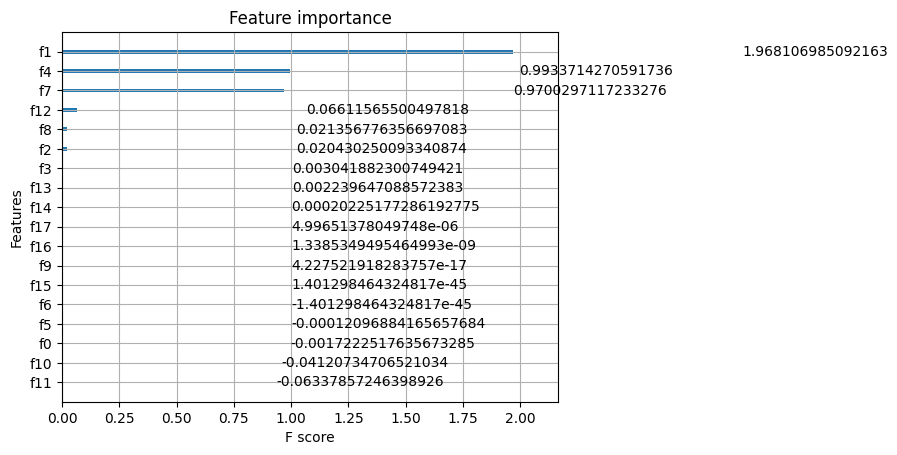

In [512]:
xgb.plot_importance(bstr)

In [471]:
feats = np.array([1, 4, 7])
np.array(allPerfCols)[xIdx][feats]

array(['FGM', 'FG3M', 'FTM'], dtype='<U7')

We see that the relationship is near perfect and we even see that the sensitives give us the correct linear relationship: 2*FGM + FTM + FG3M = PTS.</br>

Let's put this all in a function, remove the colinear PCT, PTS, and REB features, and map 'fX' lables to the original feature names.

In [617]:
allPerfCols = ['MIN_NUM', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF']

def rollingWindow(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def getAngle(left, mid, right):
    leg1 = (left - mid)**2 + 1
    leg2 = (mid - right)**2 + 1
    hyp = (left - right)**2 + 4
    return (leg1 + leg2 - hyp)/np.sqrt(2*leg1*leg2)

def getElbowIdx(vals):
    return np.argmax(np.apply_along_axis(
            lambda x: getAngle(x[0], x[1], x[2]), 1,
            rollingWindow(vals, 3))) + 1

def checkSensitivity(col, pid, season):
    checkIdx = allPerfCols.index(col)

    allPerfIdx = np.arange(len(allPerfCols))
    xIdx = allPerfIdx[allPerfIdx != checkIdx]
    yIdx = allPerfIdx[allPerfIdx == checkIdx]

    trainData = games_details[(games_details['PLAYER_ID'] == pid) & (games_details['SEASON'] < season)][allPerfCols].values
    trainX, trainY = trainData[:,xIdx], trainData[:,yIdx]
    testData = games_details[(games_details['PLAYER_ID'] == pid) & (games_details['SEASON'] == season)][allPerfCols].values
    testX, testY = testData[:,xIdx], testData[:,yIdx]

    XY = xgb.DMatrix(trainX, trainY)
    testXY = xgb.DMatrix(testX, testY)

    evals_result = dict()
    bstr = xgb.train({
        'objective': 'reg:squarederror',
        'booster': 'gblinear',
        'alpha': 0.1,  # apply both L1/L2 regularization to stabilize results
        'lambda': 0.1,
    }, XY, num_boost_round=1000, early_stopping_rounds=5, evals=[(XY, 'Train'), (testXY, 'Test')], verbose_eval=False, evals_result=evals_result)

    weights = dict(sorted(bstr.get_score(importance_type='weight').items(), key=lambda x: np.abs(x[1]), reverse=True))
    vals = list(weights.values())
    cumVals = np.cumsum(vals)/np.sum(vals)

    importantFeaturesIdx = getElbowIdx(cumVals)

    # get the normalized error and sensitive features
    return evals_result['Test']['rmse'][-1]/testY.mean(), {
        np.array(allPerfCols)[xIdx][int(f[1:])] : w
        for i, (f, w) in enumerate(weights.items())
        if i <= importantFeaturesIdx
    }

Testing 2 examples below

In [618]:
checkSensitivity('MIN_NUM', 201596, 2011)

(0.18891616184401414,
 {'FGM': 1.1208666563034058,
  'STL': 1.0087870359420776,
  'DREB': 0.984628438949585,
  'TO': 0.7008092999458313,
  'AST': 0.6287667751312256,
  'OREB': 0.5404468178749084,
  'FG3A': 0.4555664658546448,
  'FG3M': 0.4070427417755127,
  'FTM': 0.4063645601272583,
  'FTA': 0.39889729022979736})

In [619]:
checkSensitivity('FGM', 201596, 2011)

(0.3026373516128466, {'FG3M': 0.5709449648857117, 'FGA': 0.37243345379829407})

Now we will run a check across all features and find the best fitting

In [622]:
allResults = dict()
for col in allPerfCols:
    allResults[col] = checkSensitivity(col, 201596, 2011)

In [623]:
dict(sorted(allResults.items(), key=lambda x: x[1][0]))

{'MIN_NUM': (0.18767727526819825,
  {'STL': 0.9788533449172974,
   'FGM': 0.9783017039299011,
   'FG3M': 0.7958835363388062,
   'DREB': 0.6268446445465088,
   'OREB': 0.5911608338356018,
   'TO': 0.5896061658859253,
   'AST': 0.5782018899917603,
   'FTA': 0.409979909658432,
   'FTM': 0.31081247329711914,
   'FG3A': 0.25018519163131714}),
 'FGA': (0.227554371666091,
  {'FGM': 0.8088825941085815, 'FG3A': 0.7808889746665955}),
 'FGM': (0.3026373499451471,
  {'FG3M': 0.5709449648857117, 'FGA': 0.3724334239959717}),
 'FG3A': (0.3364877365717776,
  {'FG3M': 0.841739296913147, 'FGA': 0.38496652245521545}),
 'FTA': (0.39580750297596873,
  {'FTM': 1.0583235025405884, 'MIN_NUM': 0.01152054127305746}),
 'FTM': (0.42089156059911265,
  {'FTA': 0.7392529249191284, 'MIN_NUM': 0.0010499591007828712}),
 'FG3M': (0.512804170237865,
  {'FG3A': 0.35437166690826416, 'FGM': 0.29944050312042236}),
 'PF': (0.5166848363405979,
  {'STL': -0.04981324076652527,
   'FG3A': 0.03921700641512871,
   'TO': 0.038602862

It seems that using this technique, the number of minutes played is the most predictable variable from the rest.</br>
This prediction isn't amazing, but pretty close. But it makes sense that the more time a player is in the game, the more performance stats he can accumulate.</br>
The next best predictions are the ones related to the ratio of Made / Attempted. This also makes sense as it is a scoring accuracy/precision measure that could be very linked to a player.

With this I finish the assignment on finding correlations between a player's performance statistics, with the following notes:
* It's also possible to continue exploring deviations of a player's stats from a running average of all players within a moving window.
* Another possible exploration is the player's ranked stat - e.g. FG_PCT rank for each player within a season, and then checking it from season to season.